# Word2Vec(Skip-Gram mode)

In [1]:
import collections
import math
import os
import random
import zipfile
import urllib.request
import numpy as np
import tensorflow as tf

### 1. 下载文本数据

In [2]:
url = "http://mattmahoney.net/dc/"

def maybe_download(filename, expected_bytes):
    if not os.path.exists(filename) :
        filename, _ = urllib.request.urlretrieve(url+filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print("found and verified", filename)
    else:
        print(statinfo.st_size)
        raise Exception("Failed to verify" +  filename + '. Can you get to it with a browser?')
    return filename

In [3]:
filename = maybe_download("text8.zip", 31344016)

found and verified text8.zip


In [4]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

In [5]:
words = read_data(filename)
print('Data Size: ',len(words))

Data Size:  17005207


In [6]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count,  dictionary, reverse_dictionary, 

In [7]:
data, count, dictionary, reverse_dictionary = build_dataset(words)


In [8]:
del words
print('Most common words (+UNK) ', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK)  [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5238, 3084, 12, 6, 195, 2, 3137, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


生成训练样本，label

In [9]:
data_index = 0

def generate_batch(batch_size, num_skip, skip_window):
    global data_index
    assert batch_size%num_skip ==  0
    assert num_skip <= 2*skip_window
    batch = np.ndarray(shape=[batch_size], dtype=np.int32)
    labels = np.ndarray(shape=[batch_size, 1], dtype=np.int32)
    span = 2*skip_window+1
    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index+1)%len(data)
    for i in range(batch_size//num_skip):
        target = skip_window
        targets_to_avoid = [skip_window ]
        for  j in range(num_skip):
            while target in targets_to_avoid:
                target = random.randint(0, span -1)
            targets_to_avoid.append(target)
            batch[i*num_skip +j] = buffer[skip_window]
            labels[i*num_skip +j] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index+1)%len(data)
    return batch, labels

In [10]:
batch, labels = generate_batch(batch_size=8, num_skip=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]], '-->', labels[i, 0], reverse_dictionary[labels[i, 0]])

3084 originated --> 5238 anarchism
3084 originated --> 12 as
12 as --> 3084 originated
12 as --> 6 a
6 a --> 12 as
6 a --> 195 term
195 term --> 2 of
195 term --> 6 a


参数初始化

In [11]:
batch_size = 128
embedding_size = 128
skip_window = 1
num_skips  = 2

valid_size = 16
valid_window = 100
valid_example =  np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64

定义 Skip-Gram Word2Vec 模型的网络结构

In [12]:
graph = tf.Graph()
with graph.as_default() :
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_example, dtype=tf.int32)
    
    with tf.device('/cpu:0'):
        embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
        
        nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0/math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
        
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights, biases=nce_biases, labels=train_labels,
                                         inputs=embed, num_sampled=num_sampled, num_classes=vocabulary_size))
    
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings/norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,  valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
    init = tf.global_variables_initializer()

In [13]:
num_steps = 100001
with tf.Session(graph=graph) as session:
    init.run()
    print("Initialized")
    
    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs:batch_inputs, train_labels:batch_labels}
        
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss  += loss_val
        
        if step%2000 ==0:
            if step > 0:
                average_loss /=2000
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0
            
        if step%10000 ==0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_words = reverse_dictionary[valid_example[i]]
                top_k=8
                nearest = (-sim[i,:]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:"%valid_words
                
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," %(log_str, close_word)
                print(log_str)
        final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  297.073730469
Nearest to that: lajos, feature, sfsr, jumbo, loosely, yeo, chickasaw, townsfolk,
Nearest to with: originator, connell, rating, cady, horner, gdynia, volt, grimoires,
Nearest to had: moldavia, material, safavids, corvinus, interludes, strength, farmers, totoro,
Nearest to they: nurse, bagpuss, bacall, dissenting, imaginable, havenco, grade, spherical,
Nearest to use: exhibiting, pravda, advisory, tori, dvorak, grue, sponsors, lgpl,
Nearest to nine: slates, seas, weiner, riigikogu, gammu, heraclius, palau, sensitive,
Nearest to who: inaccessible, interplay, cantus, yorke, anatomically, shehhi, sine, health,
Nearest to not: psychologist, ara, dumplings, composites, bones, interactions, polymaths, males,
Nearest to on: schematic, strictness, imposes, bau, cmmi, alde, levelling, czarist,
Nearest to than: glossaries, sauce, ganga, longue, partnering, norms, redirect, guatemala,
Nearest to system: baked, confess, conducive, subarctic, pipe

高维数据可视化

In [14]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels thanembeddings"
    plt.figure(figsize=(18, 18))
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',  ha='right', va='bottom')
    plt.savefig(filename)

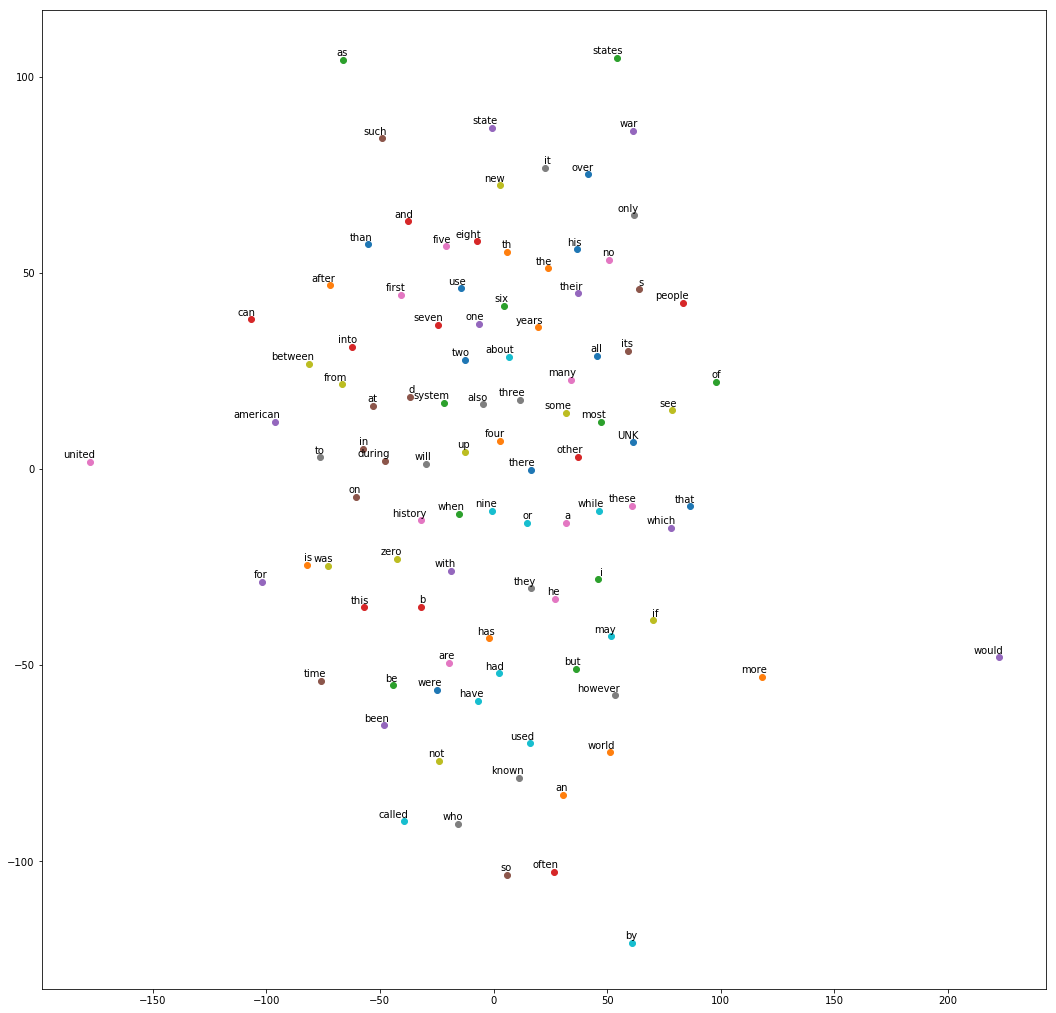

In [16]:
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 100
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)